<h1 style='text-align: center;'>Segmenting and Clustering Neighborhoods in Toronto</h1>

## Part 1. Crawling data from wikipedia and crate dataframe from it

In [1]:
#import module that used in this case
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

In [2]:
#crawling data from wikipedia page
url         = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
response    = requests.get(url)

soup        = BeautifulSoup(response.text, 'lxml')

In [3]:
#find table that we wanted
table       = soup.find('table', attrs={'class':'wikitable sortable'})

In [4]:
#iterate over row and append it to our list, then create a dataframe
postal_code = []
borough     = []
neighborhood= []

for row in table.findAll('tr'):
    col = row.findAll('td')
    if len(col) == 3:
        postal_code.append(col[0].find(text=True).replace('\n',''))
        borough.append(col[1].find(text=True).replace('\n',''))
        neighborhood.append(col[2].find(text=True).replace('\n',''))

dataframe = {'postal_code': postal_code, 'borough': borough, 'neighborhood': neighborhood}
df  = pd.DataFrame(dataframe)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)

In [5]:
#replace not assigned as nan then drop it
df['borough'].replace('Not assigned',np.nan, inplace=True)
df.dropna(axis=0, inplace=True)

In [6]:
#check neighborhood column is there a null column
df['neighborhood'].value_counts()

Downsview                                                                                                                                 4
Don Mills                                                                                                                                 2
Cedarbrae                                                                                                                                 1
Runnymede, Swansea                                                                                                                        1
Agincourt                                                                                                                                 1
Garden District, Ryerson                                                                                                                  1
East Toronto, Broadview North (Old East York)                                                                                             1
Business reply mail 

In [7]:
#check first 5 row on our dataframe
df.head()

,postal_code,borough,neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [8]:
#check our dataframe shape
df.shape

(103, 3)

### In the end, we collected about 103 row and 3 feature from wikipedia page

## Part 2. Find Coordinate

In [9]:
import geocoder

#create function for find coordinate base on postal_code
def find_latlng(postal_code):
    latlng = None

    while(latlng is None):
        g = geocoder.google(postal_code)
        finded = g.latlng

    return finded[0], finded[1]

In [ ]:
import time

#find coordinate use find_latlng then compare the performance
start       = time.time()
lat, lng    = find_latlng('M5G')

print(f'lat: {lat}\tlng: {lng}\tprocess time: {time.time()-start}')

### at first i want to use geocoder to find coordinate of the place we wanted, but because this packpage is too slow when i use it, i decide to use csv file that provided by this course

In [11]:
#load geospacial data and print first 5 row
coordinate  = pd.read_csv('Geospatial_Coordinates.csv')
coordinate.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [20]:
#merge it to our dataframe with inner join and key by postal code
df  = df.merge(coordinate, left_on='postal_code', right_on='Postal Code', how='inner')
df.drop('Postal Code', axis=1, inplace= True)
df.head()

,postal_code,borough,neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


## Part 3. cluster Toronto and visualize it

In [51]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

#lowercase borough string then find number of cluster inside it
df['borough'] = df['borough'].apply(lambda x: x.lower())
X   = df[df['borough'].str.contains('toronto')]

X   = X[['Latitude','Longitude']]
sse = []

for i in range(2,10):
    kmeans  = KMeans(n_clusters=i, random_state=46).fit(X)    
    sse.append(kmeans.inertia_)

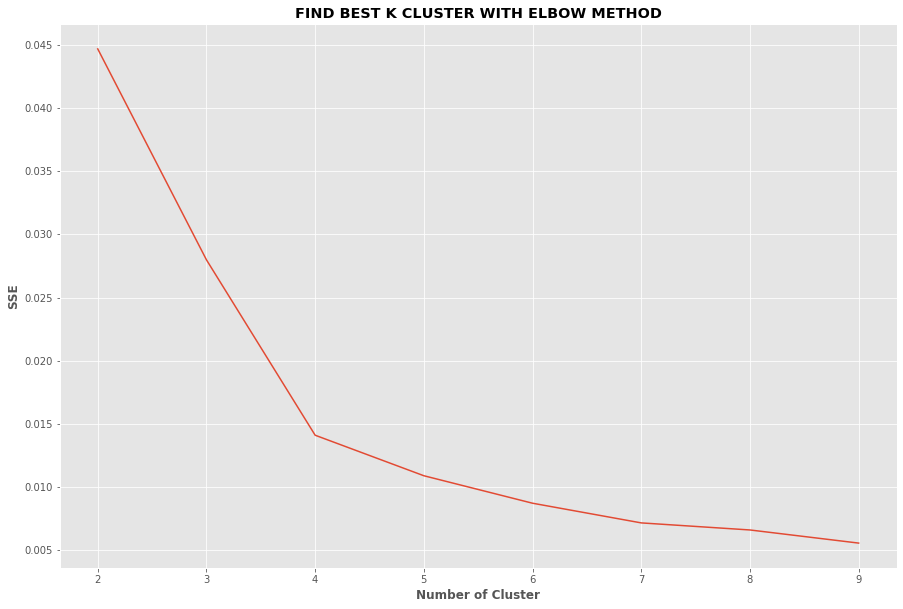

In [52]:
fig, ax = plt.subplots(figsize=[15,10])
plt.style.use('ggplot')

ax.plot(np.arange(2,10), sse)
ax.set_xlabel('Number of Cluster', fontweight='bold')
ax.set_ylabel('SSE', fontweight='bold')
ax.set_title('FIND BEST K CLUSTER WITH ELBOW METHOD', fontweight='bold')
plt.show()

### in our graphic, the most make sense K number is 4
### we use 4 for our cluster 

In [53]:
kmeans  = KMeans(n_clusters=4, random_state=46).fit(df[['Latitude','Longitude']])
df['cluster']   = kmeans.labels_
df.head()

,postal_code,borough,neighborhood,Latitude,Longitude,cluster
0,M3A,north york,Parkwoods,43.753259,-79.329656,1
1,M4A,north york,Victoria Village,43.725882,-79.315572,3
2,M5A,downtown toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2
3,M6A,north york,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0
4,M7A,downtown toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2


In [104]:
import folium
from geopy.geocoders import Nominatim

#find toronto coordinat
geolocator = Nominatim(user_agent='coursera_assignment')
location   = geolocator.geocode('toronto')

In [110]:
from matplotlib import cm
from matplotlib import colors

# set color scheme for the clusters
x = np.arange(4)
ys = [i + x + (i*x)**2 for i in range(4)]

colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [112]:
#visualize cluster throught dataset

toronto_map = folium.Map(location=[location.latitude, location.longitude], zoom_start=10)

for lt, lg, n, c in zip(df['Latitude'], df['Longitude'], df['neighborhood'], df['cluster']):
    label = f'{n}, {c}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lt, lg],
        radius=5,
        popup=label,
        color=rainbow[c-1],
        fill=True,
        fill_color=rainbow[c-1],
        fill_opacity=0.7,
        parse_html=False,        
    ).add_to(toronto_map)

In [113]:
toronto_map

### from map above, we know that our clustering is work and seem make sense , the toronto city is clustered into 4 area